## Lasso Regression
- Stock Price

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.linear_model import LassoCV,LassoLarsCV,Lasso
from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report,mean_squared_error
from imblearn.over_sampling import SMOTE
from matplotlib import pyplot as plt
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings(action="ignore", category=ConvergenceWarning)

In [2]:
tech_list = ['SMA','EMA','STOCH_k','STOCK_d','RSI','MFI','SAR','AD','MACD','MACD_Signal','MACD_Histo','VWAP','SPY','NDAQ']
funda_list = ['pcf','PEG_trailing','dpr','npm','gpm','roa','roe','capital_ratio','de_ratio','cash_ratio','curr_ratio','inv_turn','pay_turn','sale_nwc','rd_sale','accrual']
macro_list = ['gdpr1','gdpr2','cpi','bond20yr','bond30yr','fedfunds','cpir','wpir','unemp','employ']
nlp_list = ['Pos_lag2','Pos_lag3','Neg_lag1','Neg_lag2','Neg_lag3','Neu_lag1','Neu_lag2','Neu_lag3']
stock_list = ['AAPL','AMZN','BRK-B','GOOG','JNJ','META','MSFT','NVDA','TSLA','V']

We found that when 5 features are selected Lasso perfomes best on predicting the stock price

/Users/DELL/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 1.7023160047510828, tolerance: 1.1951497851608468
  model = cd_fast.enet_coordinate_descent_gram(
/Users/DELL/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 4.36882987906597, tolerance: 1.1951497851608468
  model = cd_fast.enet_coordinate_descent_gram(
/Users/DELL/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:617: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 5.593030985004816, tolerance: 1.1951497851608468
  model = cd_fast.enet_coordinate_descent_gram(
/Users/DELL/opt/anaconda3/lib/python3.9/site-packages/skle

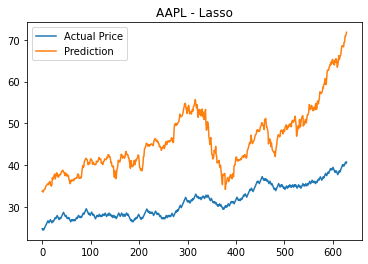

AAPL 15.503564678685473


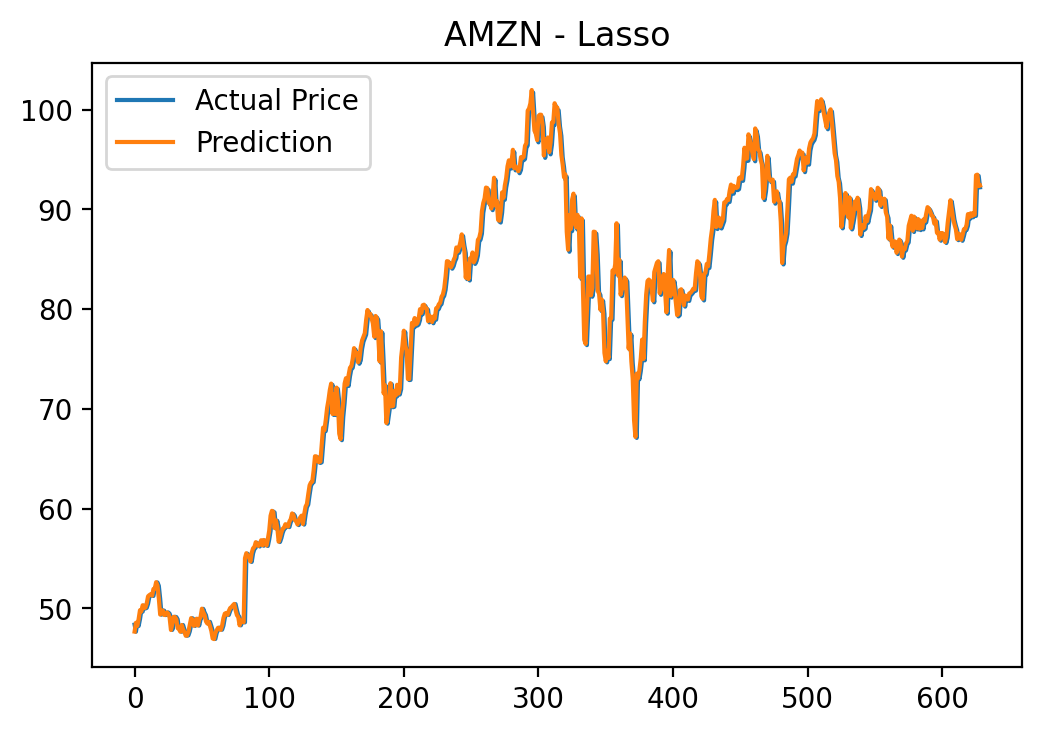

AMZN 1.4581016235801083


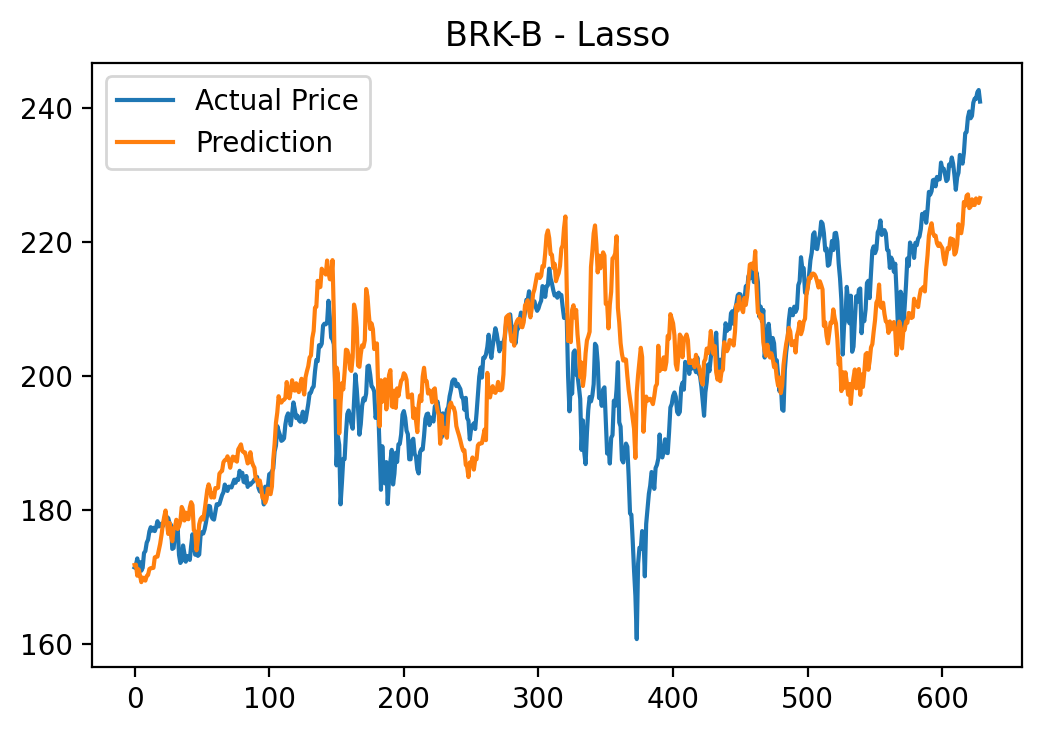

BRK-B 9.022853451602884


/Users/DELL/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 8.240e+00, tolerance: 7.117e+00
  model = cd_fast.enet_coordinate_descent(
/Users/DELL/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.039e+01, tolerance: 7.117e+00
  model = cd_fast.enet_coordinate_descent(
/Users/DELL/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation.

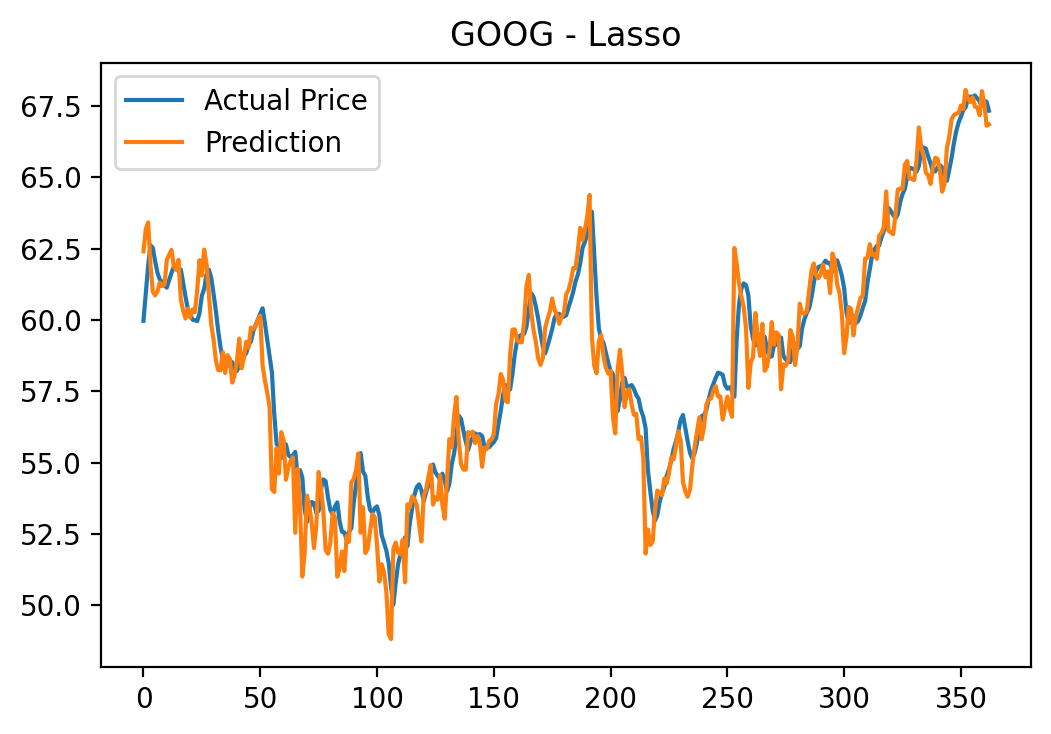

GOOG 1.1376351109990104


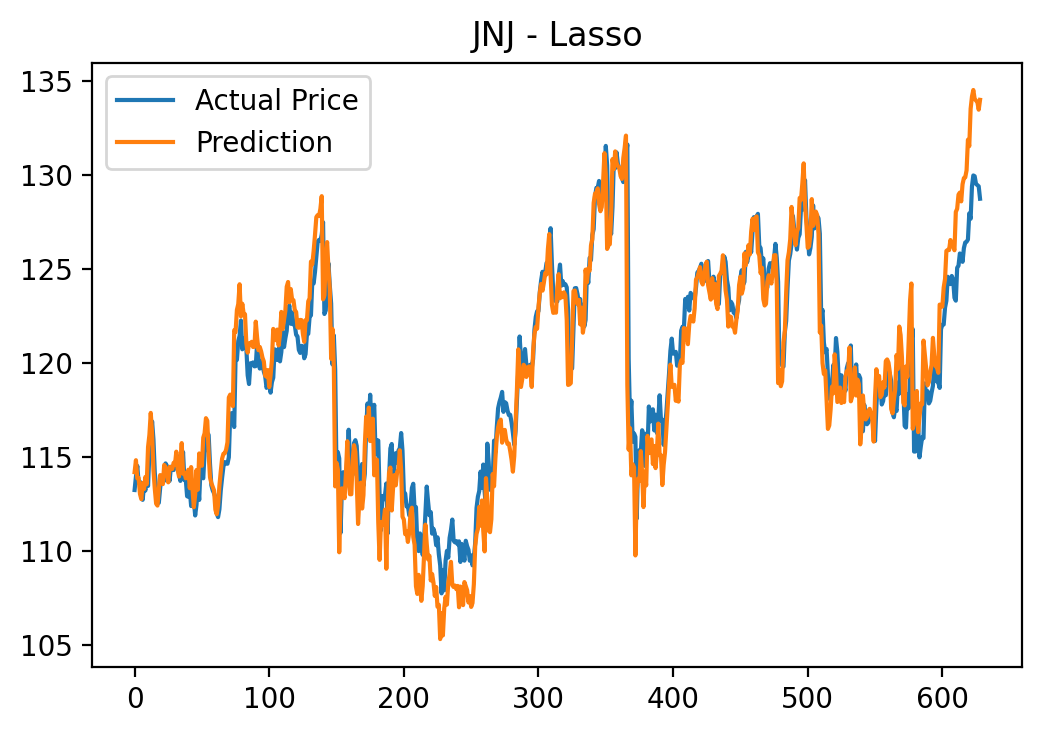

JNJ 1.8902394289942004


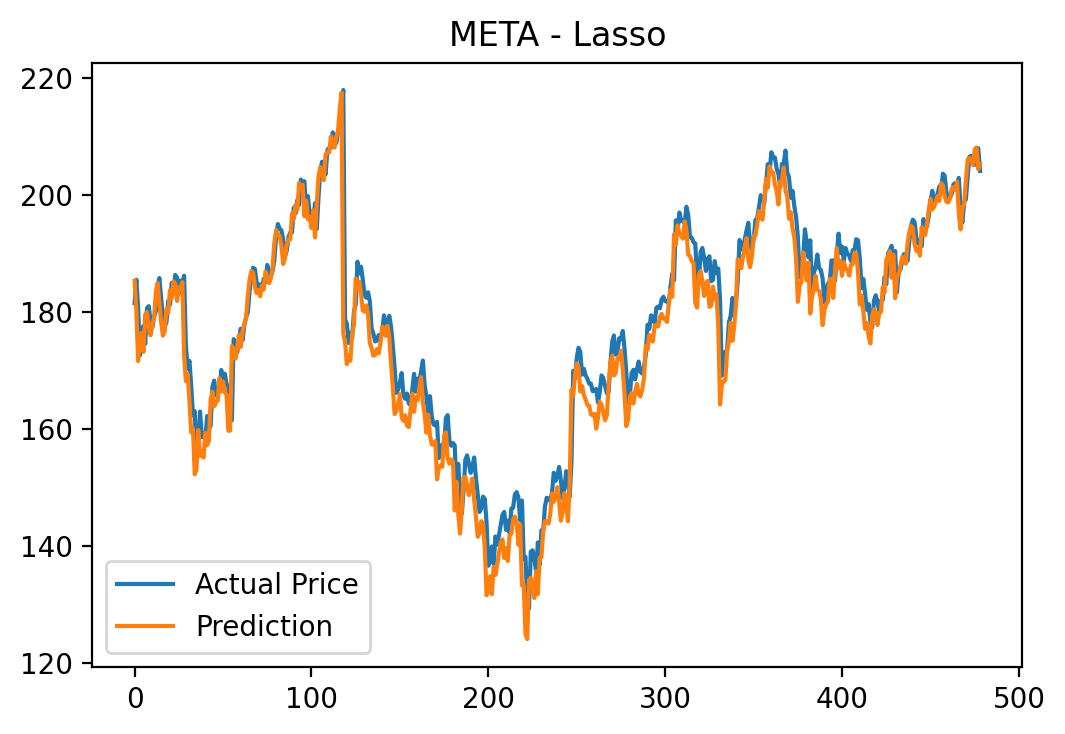

META 4.66931057412708


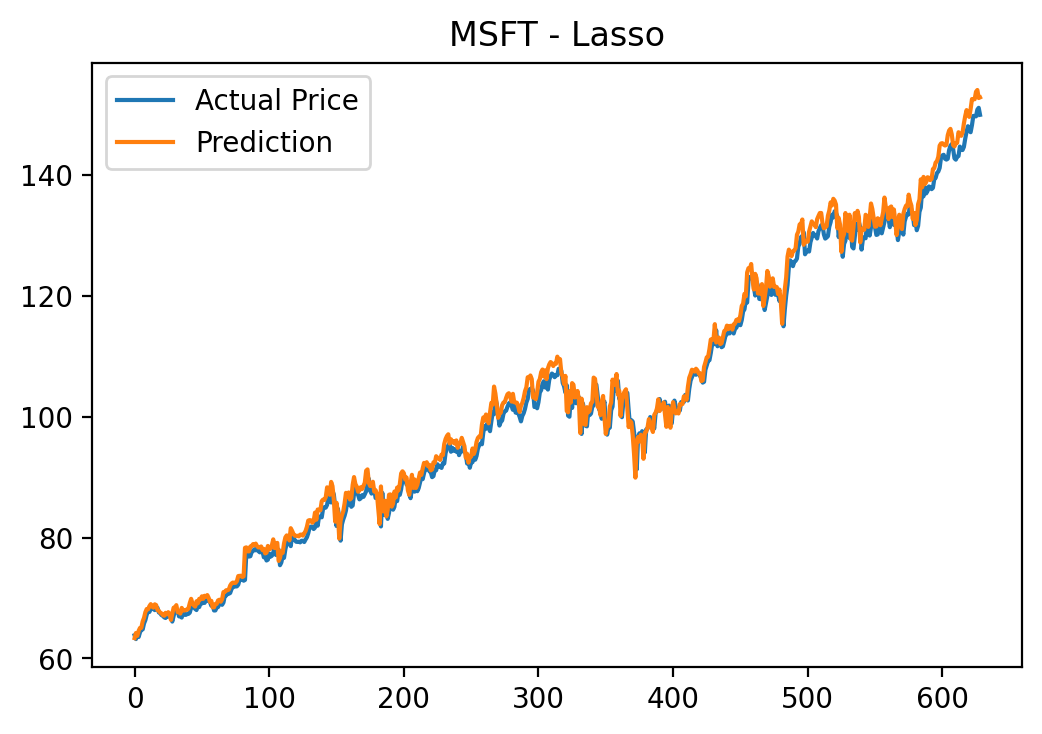

MSFT 1.9569948813657472


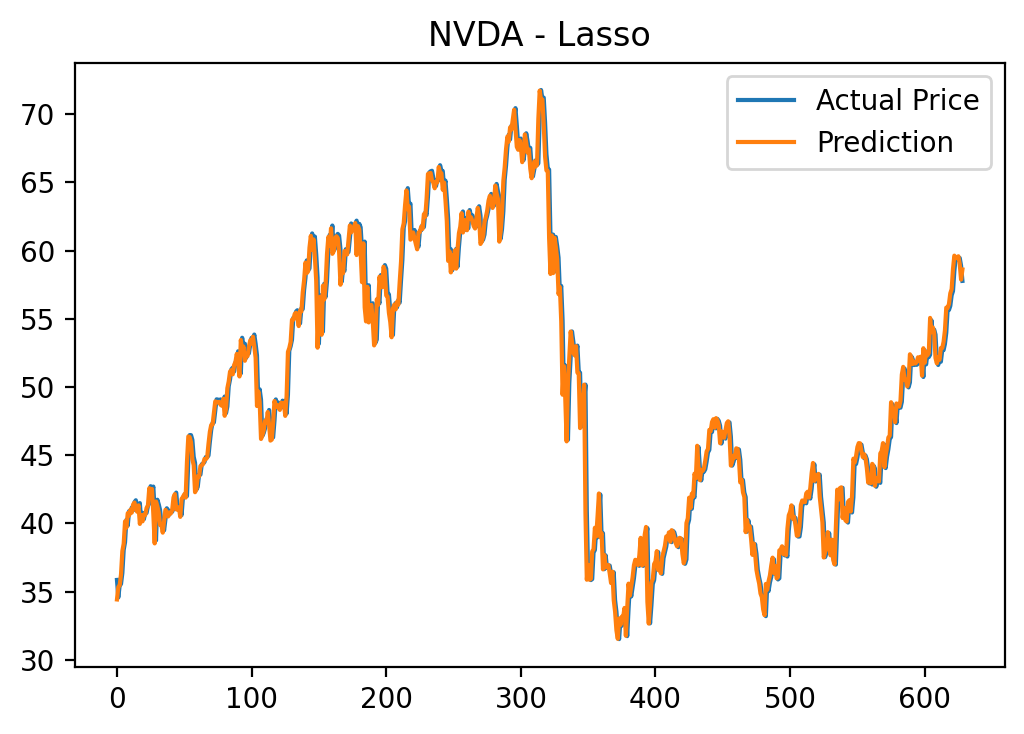

NVDA 1.3114484364656573


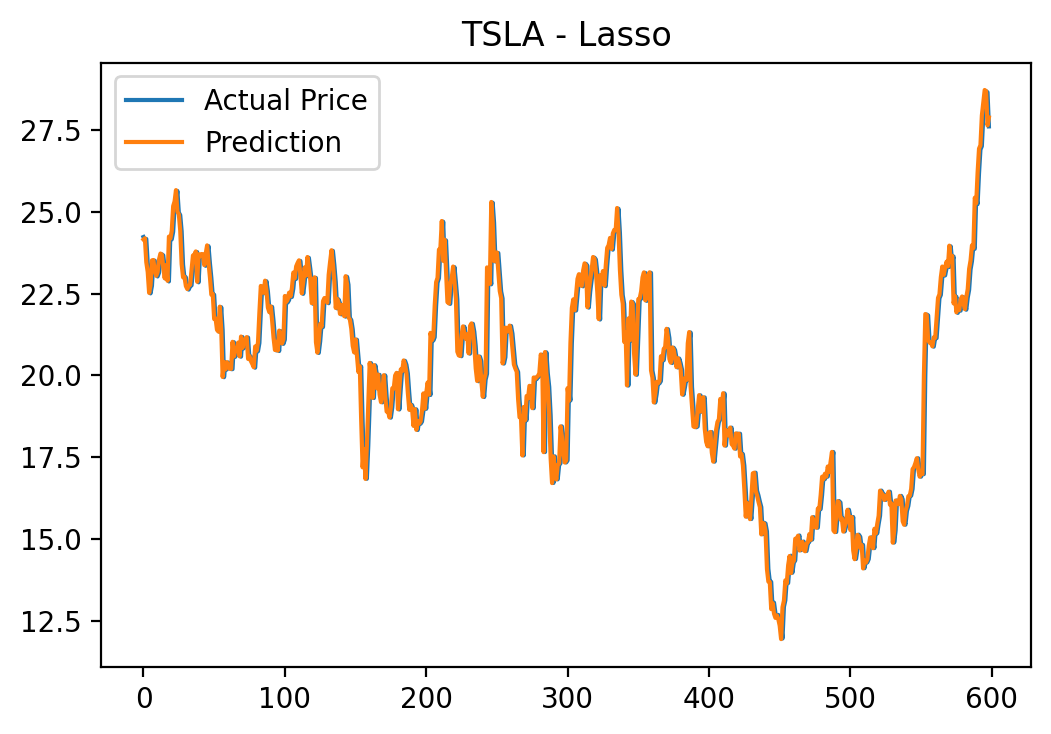

TSLA 0.6363408393472444


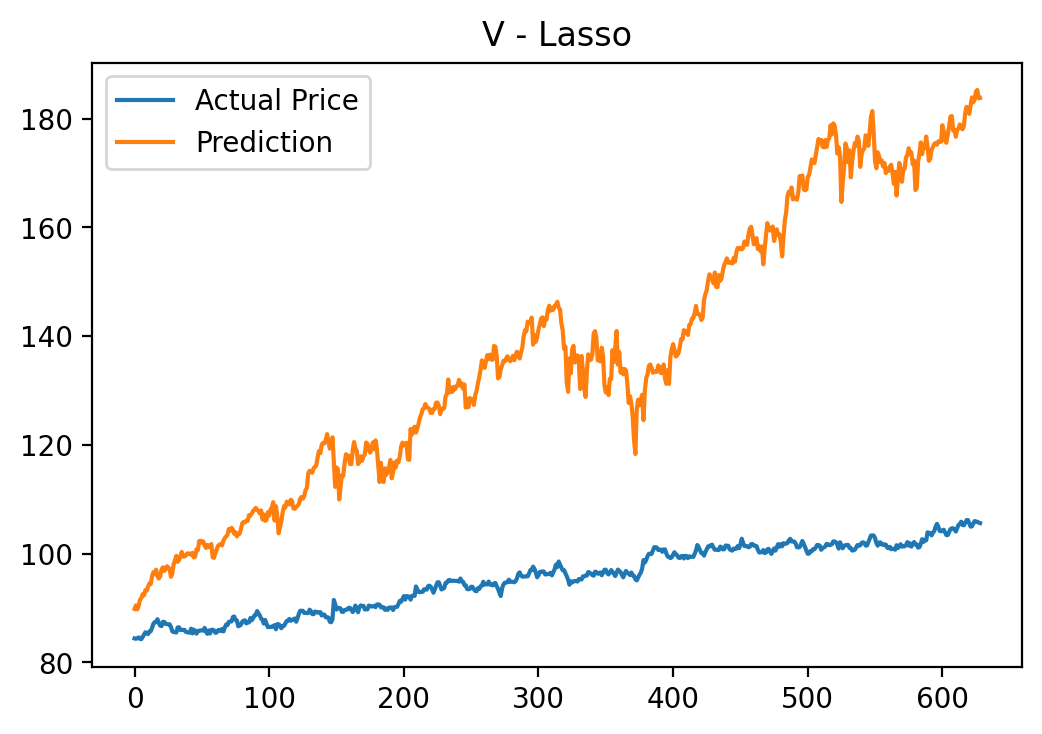

V 46.1572116415159


/var/folders/dy/lg_nw1516758wqn78l6dnqch0000gn/T/ipykernel_4087/563729723.py:65: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse_df = mse_df.append(scores, ignore_index=True)


In [3]:
warnings.filterwarnings(action="ignore", category=ConvergenceWarning)
stock_score = dict()
scores ={}
selection_collect = dict()
mse_df = pd.DataFrame(columns=stock_list)
mse_daily = {}
for j in stock_list:
    freq = 'Daily'
    stock = j
    price = pd.read_csv('../encode_price/'+freq+'/'+stock+'.csv')
    price = price.loc[(price.Date<='2019-12-31')&(price.Date>='2010-01-04'),:]
    price = price.loc[(price.Date>='2010-01-04'),:]
    y = price.adjusted_close.shift(-1).values[:-1]
    predictors = pd.read_csv('../predictors/Merged/'+freq+'/'+stock+'.csv')
    NLP = pd.read_csv('../predictors/NLP/Daily/NYT_macro_SA.csv')
    predictors = pd.merge(predictors,NLP,how='left',on=['Date'])
    predictors = predictors.loc[predictors.Date <= '2019-12-31',:]
    price.loc[:,'Date'] =[datetime.strptime(str,"%Y-%m-%d") for str in price.loc[:,'Date']]
    predictors.set_index('Date',inplace=True)
    predictors.fillna(0,inplace=True) 
    X = predictors.values[:-1]
    scores_cv = []
    for i in range(3,15):
    
        tscv = TimeSeriesSplit(n_splits=i)
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,shuffle=False)
        pipe = make_pipeline(MinMaxScaler(),Lasso())
    
        sfs = SequentialFeatureSelector(pipe,n_jobs = -1,n_features_to_select=5,scoring='neg_root_mean_squared_error').fit(X_train,y_train)
        X_train = sfs.transform(X_train)
        pipmodel = make_pipeline(MinMaxScaler(),LassoCV(cv=tscv, max_iter=1000)).fit(X_train,y_train)
        X_test =  sfs.transform(X_test)
        y_pred = pipmodel.predict(X_train)
        score = mean_squared_error(y_pred, y_train)
        scores_cv.append(score)
        
    n_split = scores_cv.index(min(scores_cv))+2
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,shuffle=False)
    tscv = TimeSeriesSplit(n_splits=n_split)
    pipe = make_pipeline(MinMaxScaler(),LassoCV(cv=tscv))
    sfs = SequentialFeatureSelector(pipe,n_jobs = -1,n_features_to_select=5,scoring='neg_root_mean_squared_error')
    sfs.fit(X_train,y_train)
    X_train = sfs.transform(X_train)
    pipmodel = make_pipeline(MinMaxScaler(),LassoCV(cv=tscv, max_iter=1000))
    pipmodel.fit(X_train,y_train)
    
    selection_collect[j] = predictors.columns.values[sfs.get_support()]
    X_test =  sfs.transform(X_test)
    y_pred = pipmodel.predict(X_test)
    dates = price.Date.shift(-1).values[:len(X)]
    dates = dates[-len(y_test):]
    plt.figure()
    plt.rcParams['savefig.dpi']=200
    plt.rcParams['figure.dpi']=200
    plt.plot(range(0,len(y_pred)),y_pred,label = 'Actual Price')
    plt.plot(range(0,len(y_pred)),y_test,label = 'Prediction')
    #plt.xticks(range(len(y_pred)),dates,rotate=45)
    plt.title(j + ' - Lasso')
    plt.legend()
    plt.savefig("../Lasso/plots/Daily/"+j+".png")
    plt.show()
    print(j,mean_squared_error(y_pred,y_test,squared=False) )
    
    scores[j] = mean_squared_error(y_pred,y_test,squared=False)
mse_df = mse_df.append(scores, ignore_index=True)


- Feature selection summary:

In [4]:
features = pd.Series(data = np.zeros(len(predictors.columns)),index=predictors.columns)
feature_selected = pd.DataFrame(selection_collect)
feature_selected.to_csv("../Lasso/results/Daily-features.csv")
for stock in stock_list:
    curr_feature = selection_collect[stock]
    for curr in curr_feature:
        features.loc[curr] += 1

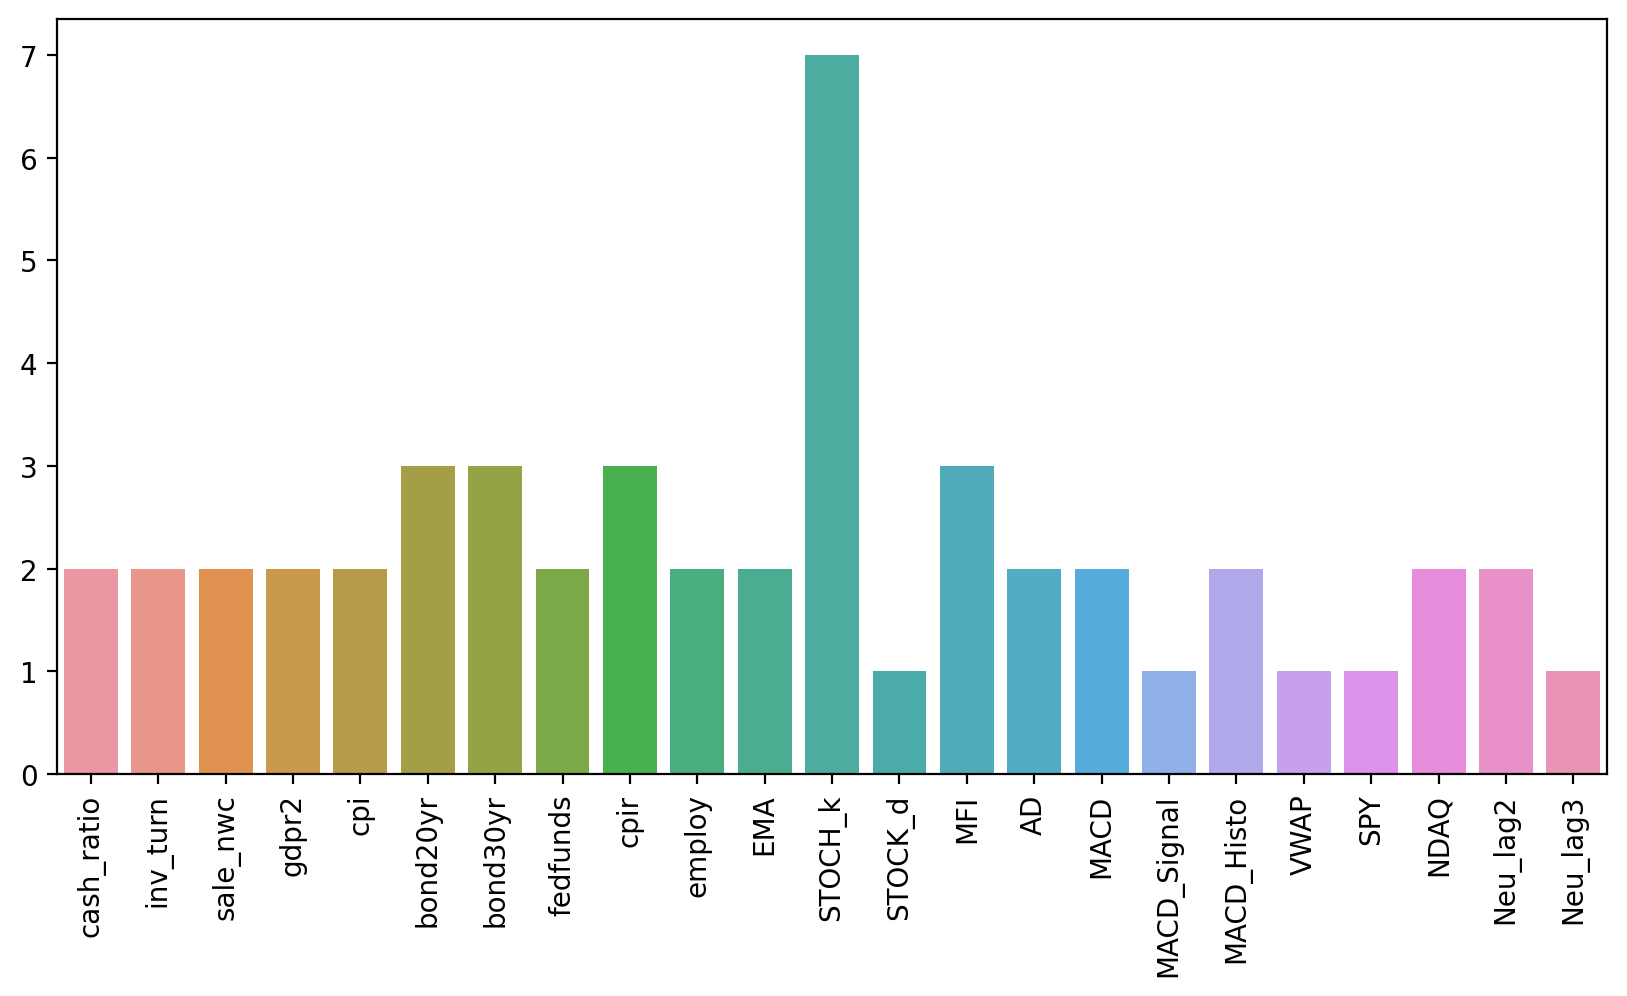

In [5]:
import seaborn as sns
usefeature = features[features!=0].index.values.tolist()

to_plot = features[features.values!=0]

plt.figure(figsize=[10,5])
ax = sns.barplot(pd.DataFrame(to_plot).T)
ax.set_xticklabels(labels=usefeature,rotation=90)
plt.savefig("../Lasso/plots/Daily/Features.png")
plt.show()

## Weekly Results

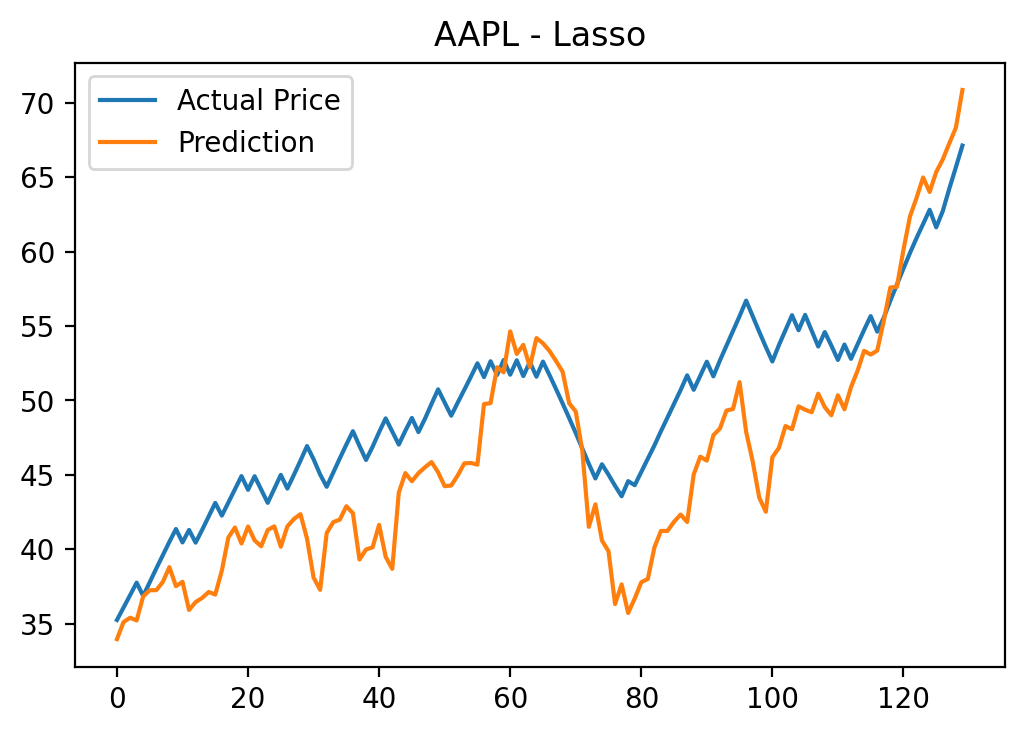

AAPL 4.925687086263646


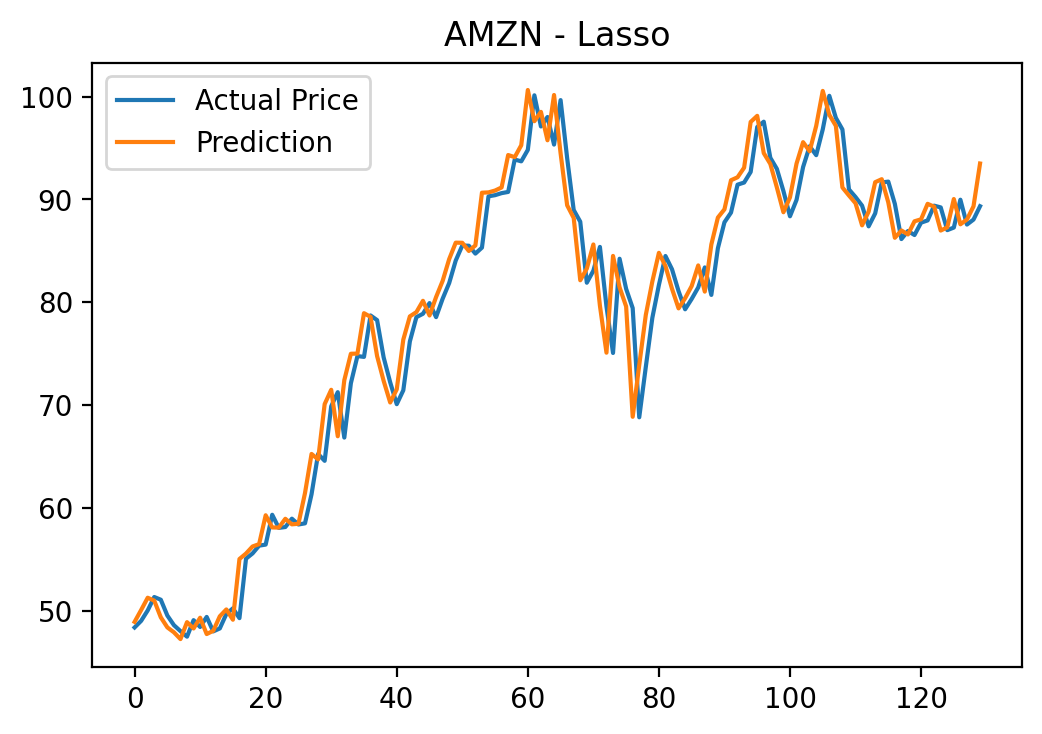

AMZN 2.8722912692050233


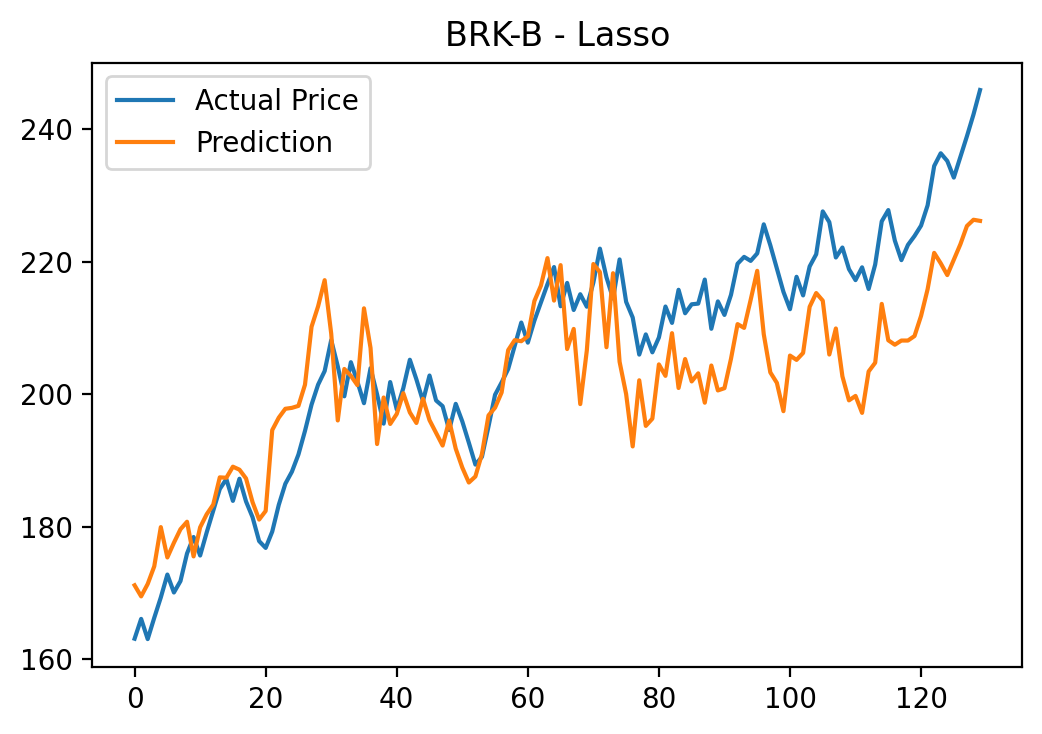

BRK-B 10.333021915144815


/Users/DELL/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.595e+01, tolerance: 1.461e+00
  model = cd_fast.enet_coordinate_descent(


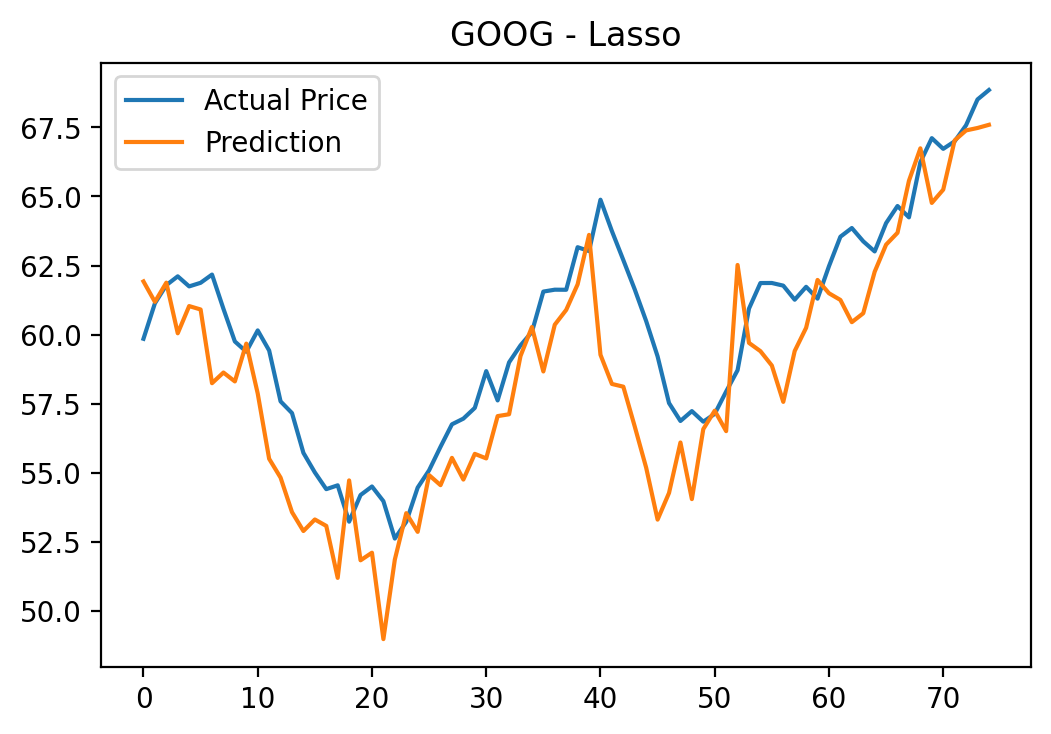

GOOG 2.4918073894991304


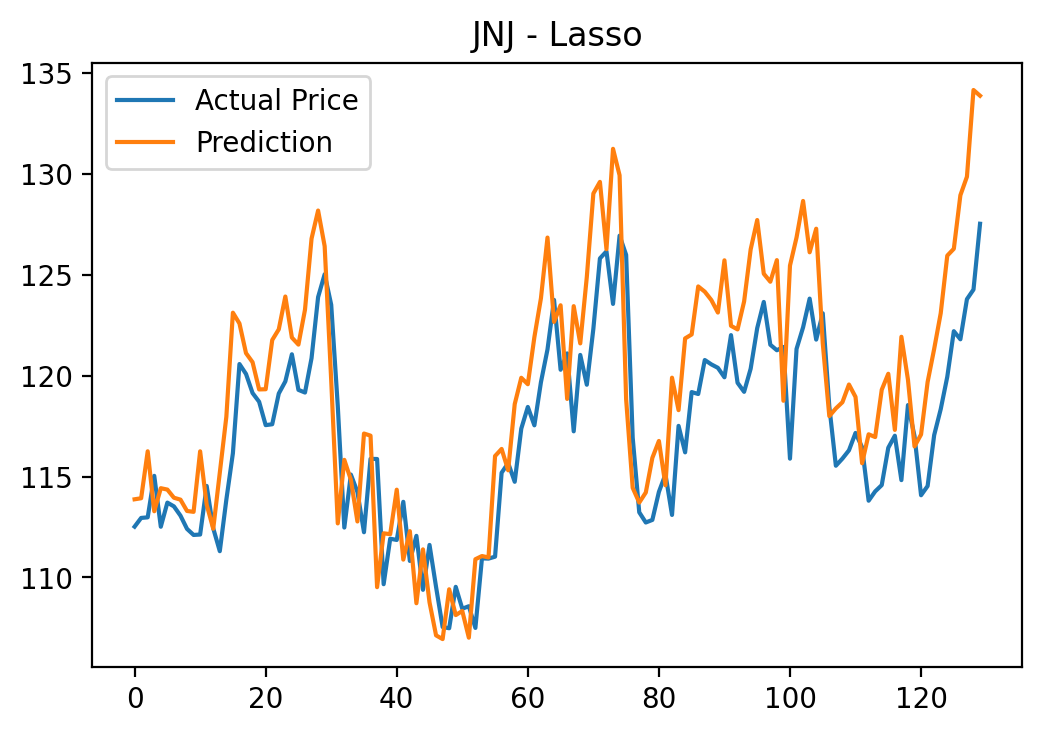

JNJ 3.7809356609196043


/Users/DELL/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 4.248e+01, tolerance: 3.697e+01
  model = cd_fast.enet_coordinate_descent(
/Users/DELL/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 5.089e+01, tolerance: 3.697e+01
  model = cd_fast.enet_coordinate_descent(
/Users/DELL/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_coordinate_descent.py:631: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation.

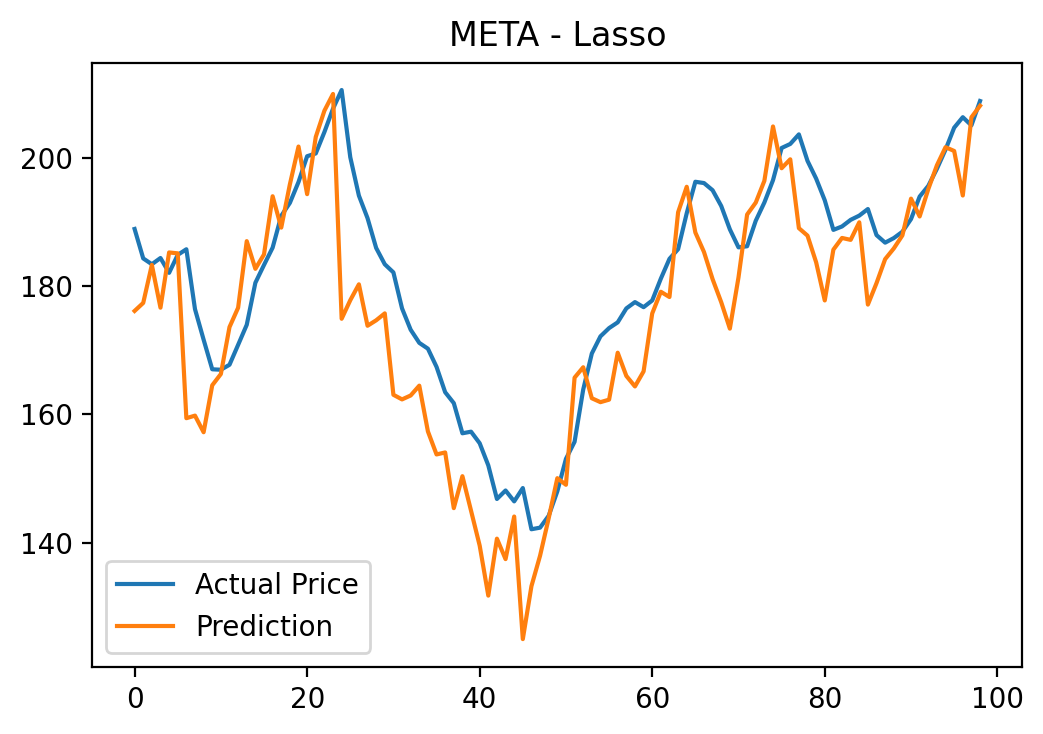

META 10.327922409800953


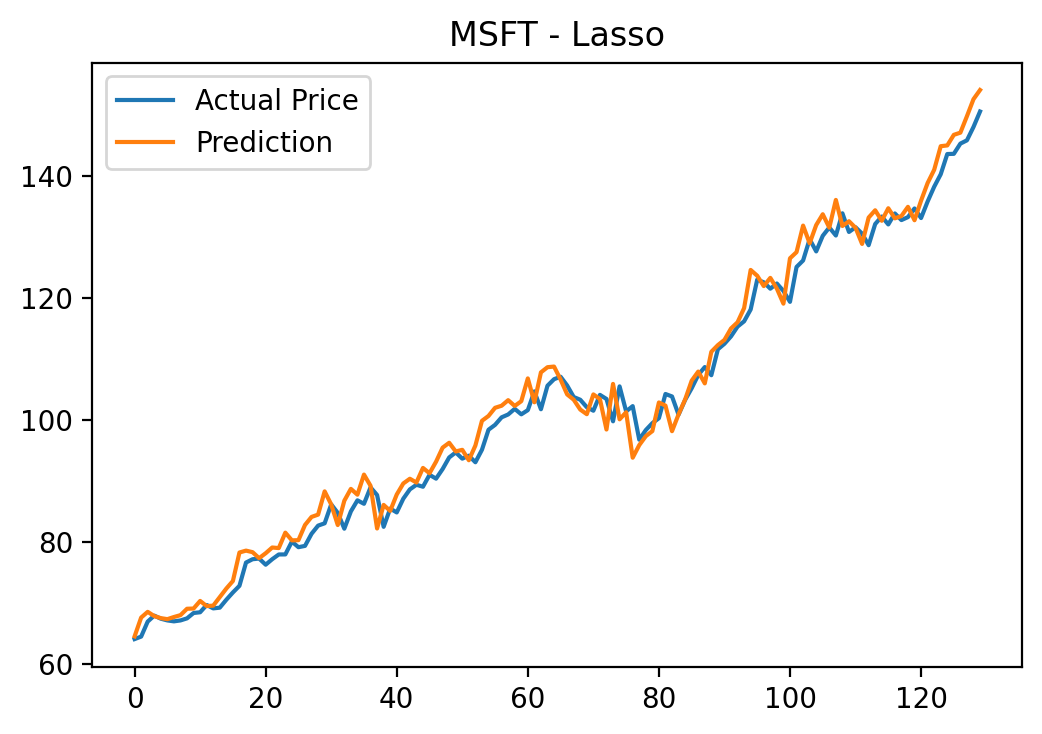

MSFT 2.8544016226687114


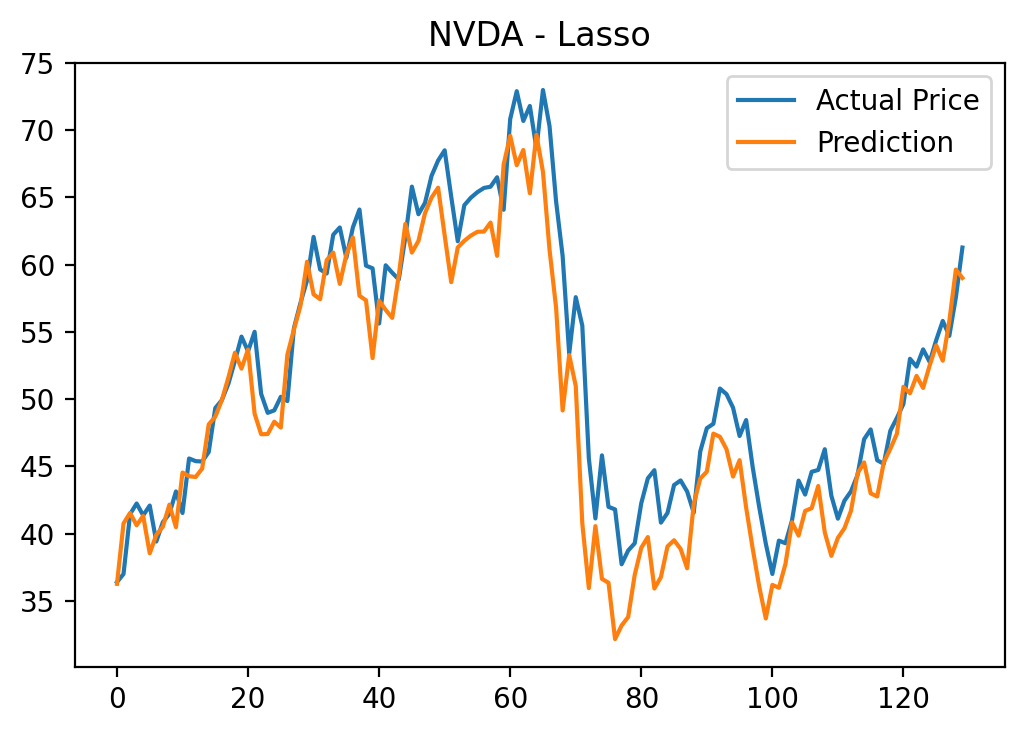

NVDA 4.02740971902942


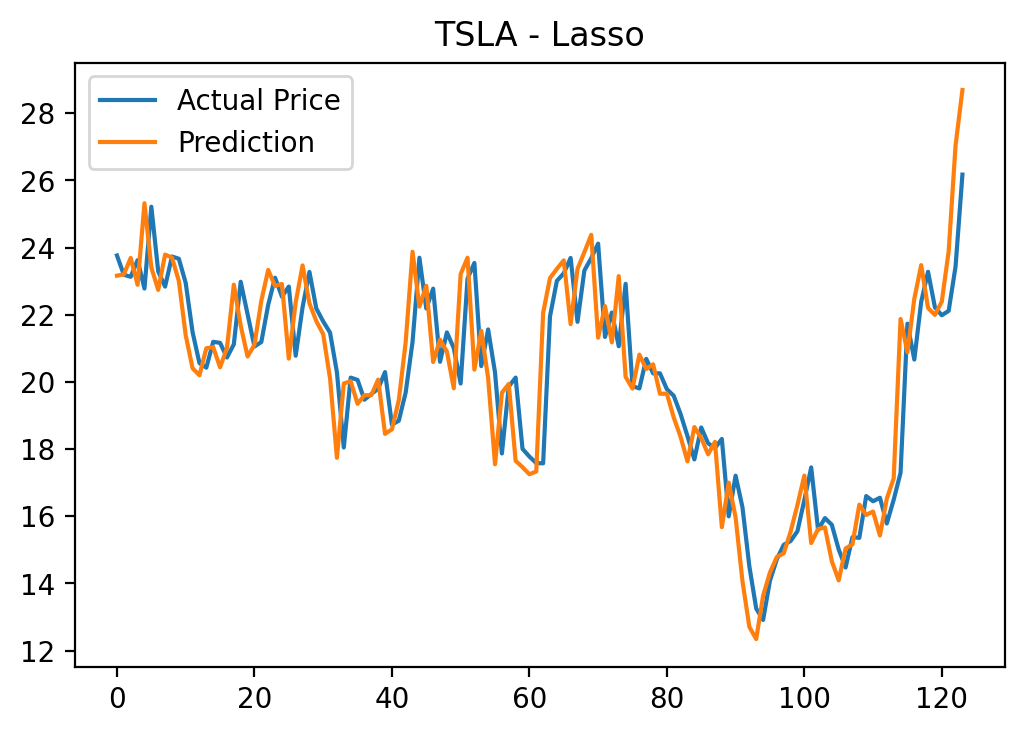

TSLA 1.4183653090547756


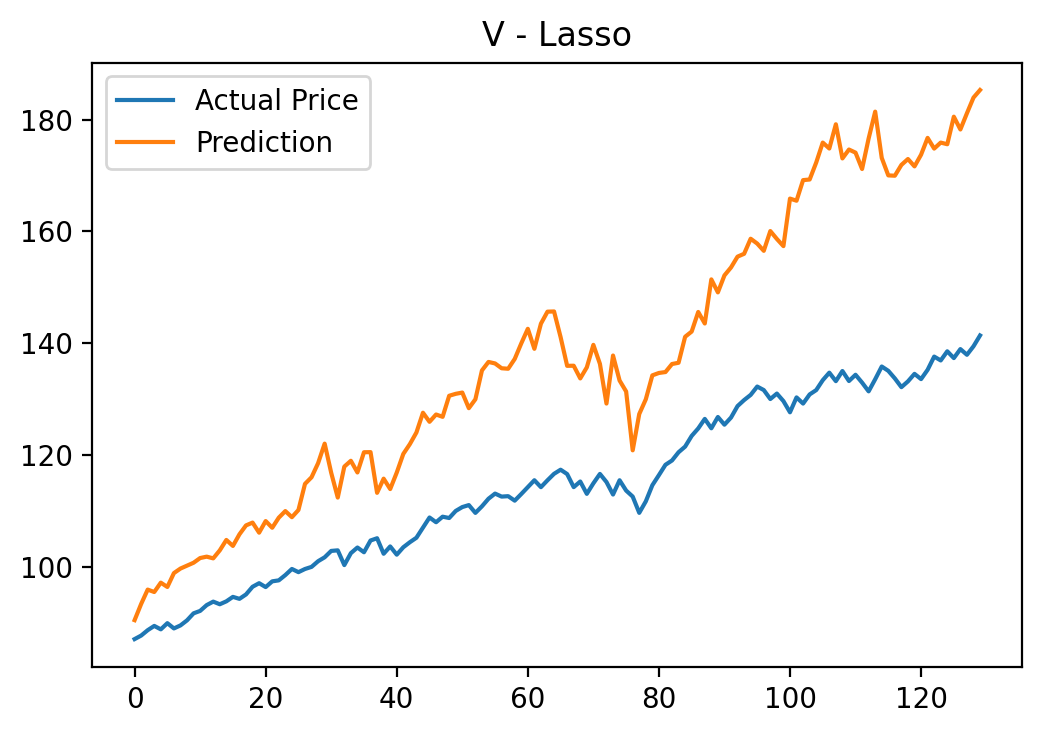

V 25.427767144731238


In [6]:
stock_score = dict()
scores ={}
for j in stock_list:
    freq = 'Weekly'
    stock = j
    price = pd.read_csv('../encode_price/'+freq+'/'+stock+'.csv')
    price = price.loc[(price.Date<='2019-12-31')&(price.Date>='2010-01-04'),:]
    price = price.loc[(price.Date>='2010-01-04'),:]
    y = price.adjusted_close.shift(-1).values[:-1]
    predictors = pd.read_csv('../predictors/Merged/'+freq+'/'+stock+'.csv')
    NLP = pd.read_csv('../predictors/NLP/Daily/NYT_macro_SA.csv')
    predictors = pd.merge(predictors,NLP,how='left',on=['Date'])
    predictors = predictors.loc[predictors.Date <= '2019-12-31',:]
    price.loc[:,'Date'] =[datetime.strptime(str,"%Y-%m-%d") for str in price.loc[:,'Date']]
    predictors.set_index('Date',inplace=True)
    predictors.fillna(0,inplace=True) 
    X = predictors.values[:-1]
    scores_cv = []
    for i in range(3,15):
        tscv = TimeSeriesSplit(n_splits=i)
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,shuffle=False)
        pipe = make_pipeline(MinMaxScaler(),Lasso())
    
        sfs = SequentialFeatureSelector(pipe,n_jobs = -1,n_features_to_select=5,scoring='neg_root_mean_squared_error')
        sfs.fit(X_train,y_train)
        X_train = sfs.transform(X_train)
        pipmodel = make_pipeline(MinMaxScaler(),LassoCV(cv=tscv))
        pipmodel.fit(X_train,y_train)
        X_test =  sfs.transform(X_test)
        y_pred = pipmodel.predict(X_train)
        score = mean_squared_error(y_pred, y_train)
        scores_cv.append(score)
    n_split = scores_cv.index(min(scores_cv))+2
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,shuffle=False)
    tscv = TimeSeriesSplit(n_splits=n_split)
    pipe = make_pipeline(MinMaxScaler(),LassoCV(cv=tscv))
    sfs = SequentialFeatureSelector(pipe,n_jobs = -1,n_features_to_select=5,scoring='neg_root_mean_squared_error')
    sfs.fit(X_train,y_train)
    X_train = sfs.transform(X_train)
    pipmodel = make_pipeline(MinMaxScaler(),LassoCV(cv=tscv))
    pipmodel.fit(X_train,y_train)
    features = sfs.get_feature_names_out()
    X_test =  sfs.transform(X_test)
    y_pred = pipmodel.predict(X_test)
    dates = price.Date.shift(-1).values[:len(X)]
    dates = dates[-len(y_test):]
    plt.plot(range(0,len(y_pred)),y_pred,label = 'Actual Price')
    plt.plot(range(0,len(y_pred)),y_test,label = 'Prediction')
    #plt.xticks(range(len(y_pred)),dates,rotate=45)
    plt.title(j + ' - Lasso')
    plt.legend()
    plt.savefig("../Lasso/plots/Daily/"+j+".png")
    plt.show()
    print(j,mean_squared_error(y_pred,y_test,squared=False) )
    scores[j] = mean_squared_error(y_pred,y_test,squared=False)

- Feature Selection Summary

/var/folders/dy/lg_nw1516758wqn78l6dnqch0000gn/T/ipykernel_4087/3912607966.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse_df = mse_df.append(scores,ignore_index=True)


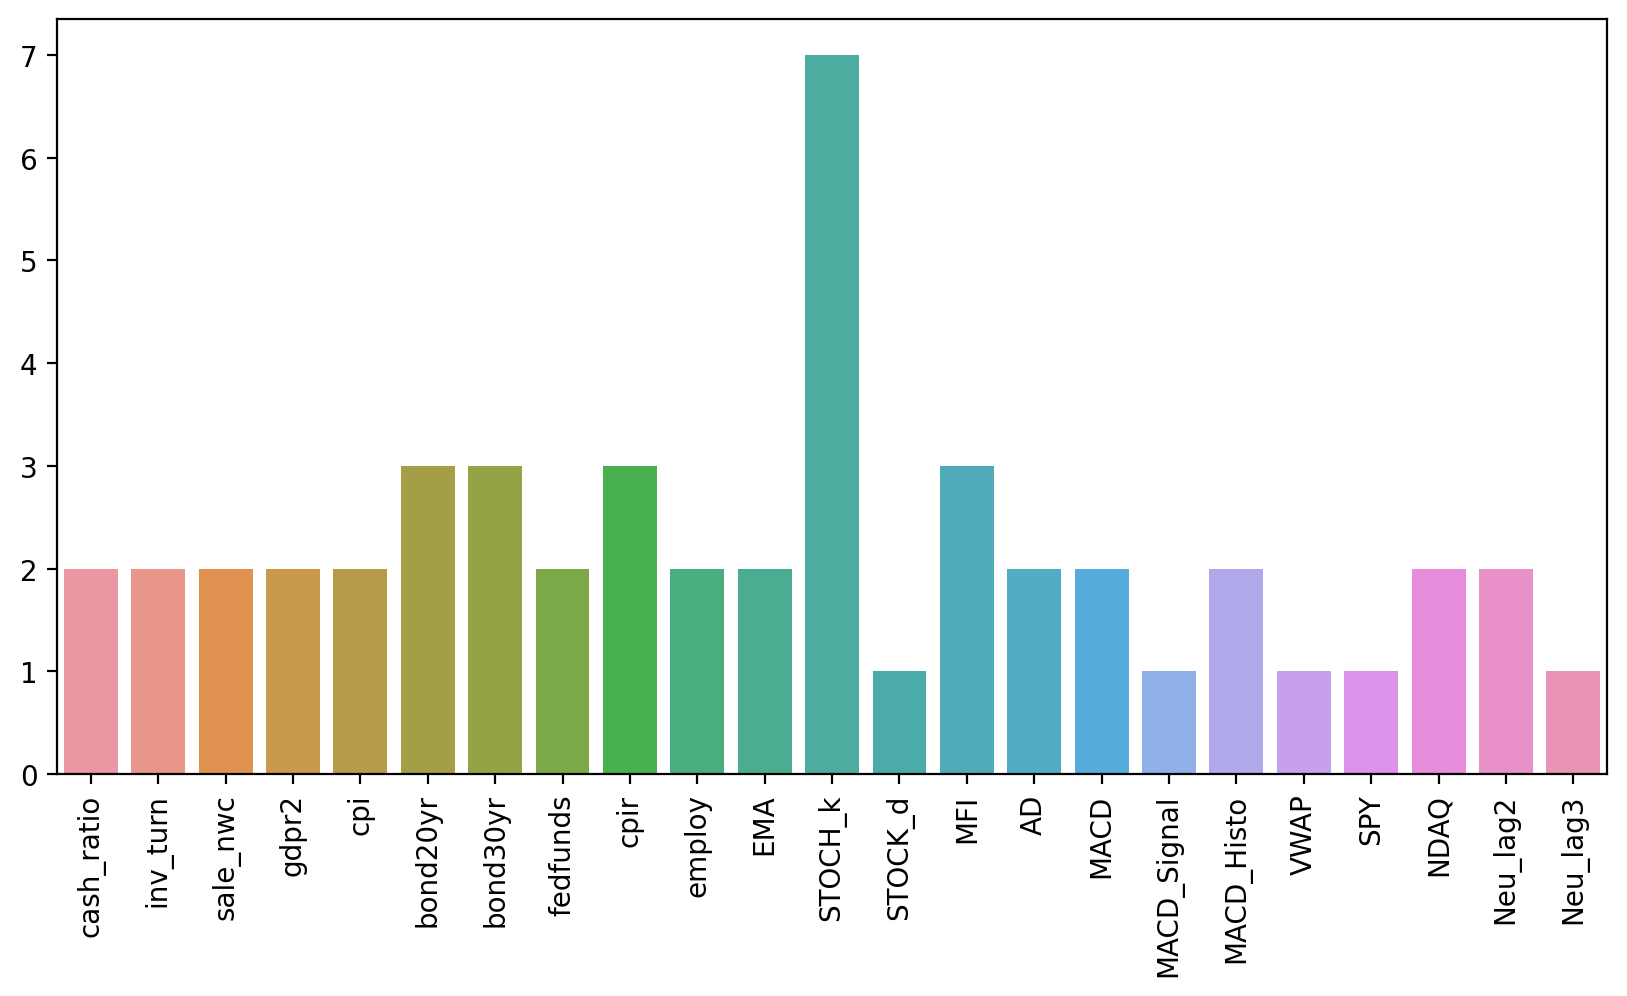

In [7]:
features = pd.Series(data = np.zeros(len(predictors.columns)),index=predictors.columns)
mse_df = mse_df.append(scores,ignore_index=True)
for stock in stock_list:
    curr_feature = selection_collect[stock]
    for curr in curr_feature:
        features.loc[curr] += 1
        
usefeature = features[features!=0].index.values.tolist()
plt.figure(figsize=[10,5])
ax = sns.barplot(features[features!=0].to_frame().T)
ax.set_xticklabels(labels=usefeature,rotation=90)
plt.savefig("../Lasso/plots/Weekly/Features.png")
plt.show()


### Monthly Results

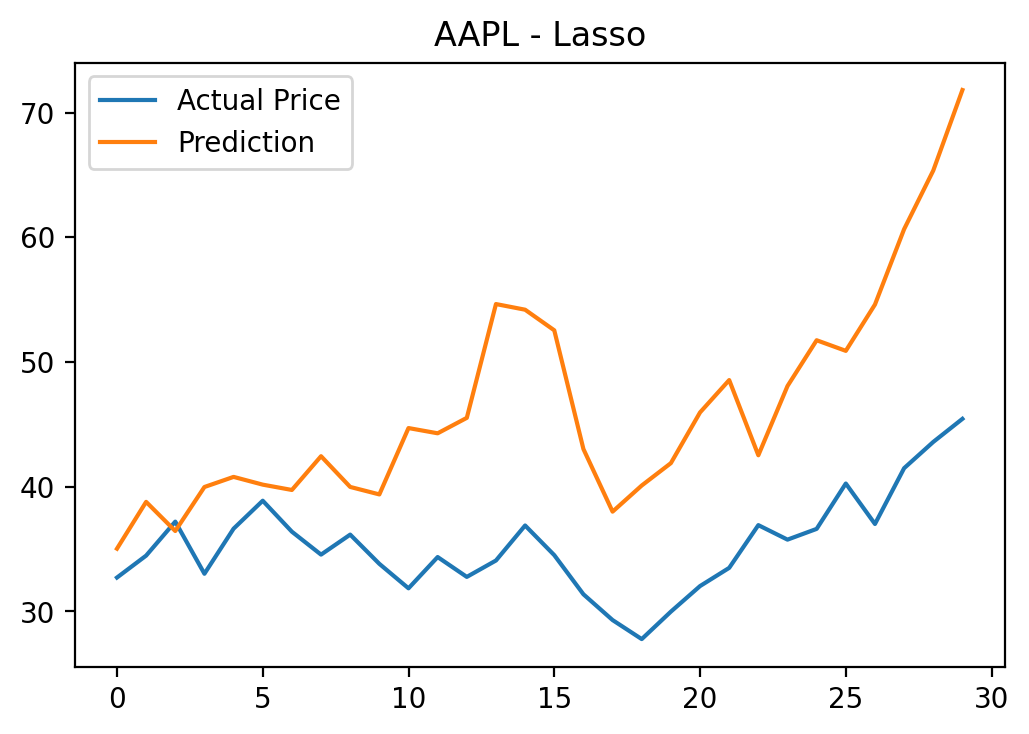

AAPL 12.884617214336282


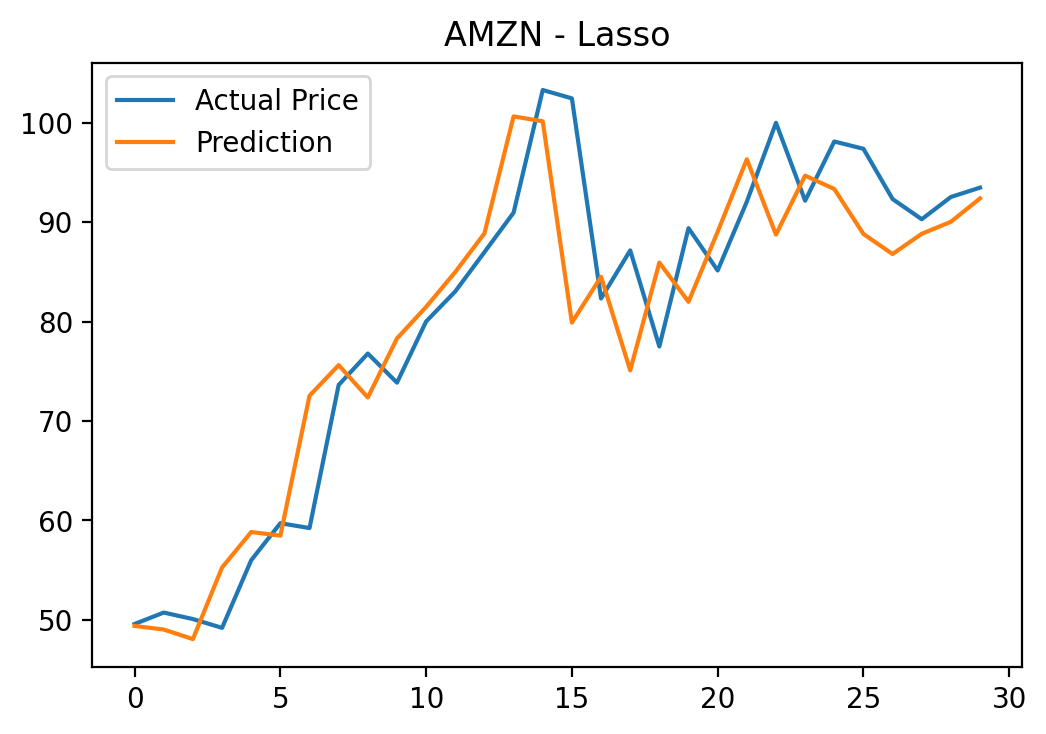

AMZN 7.010056466810002


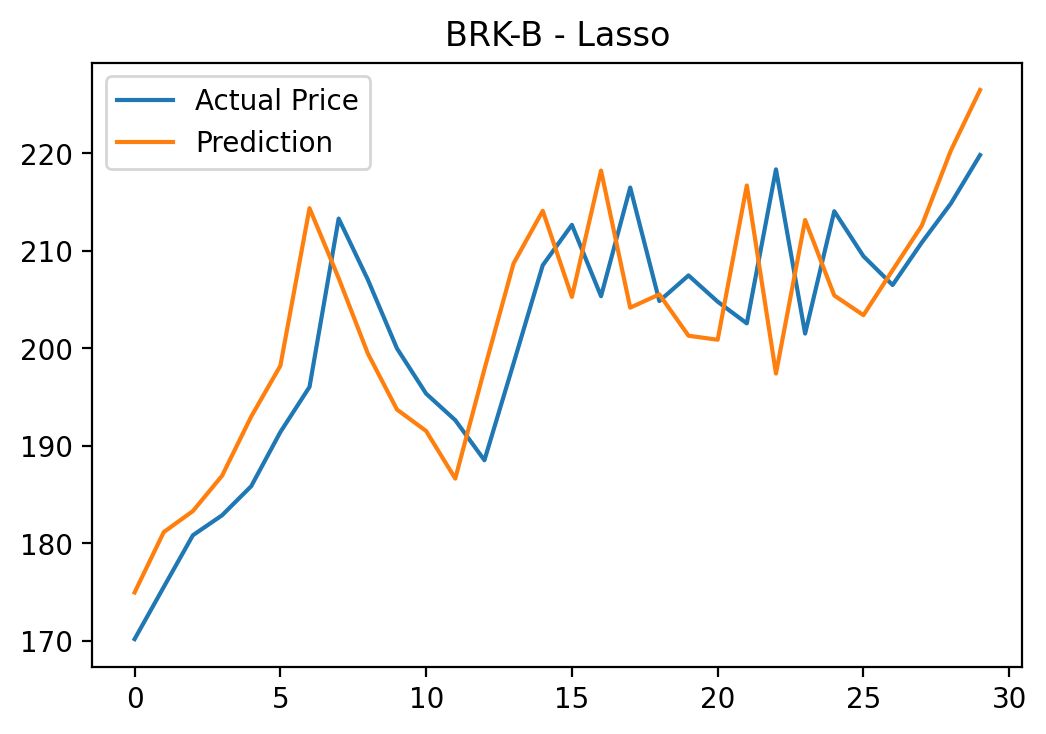

BRK-B 8.773904972254485


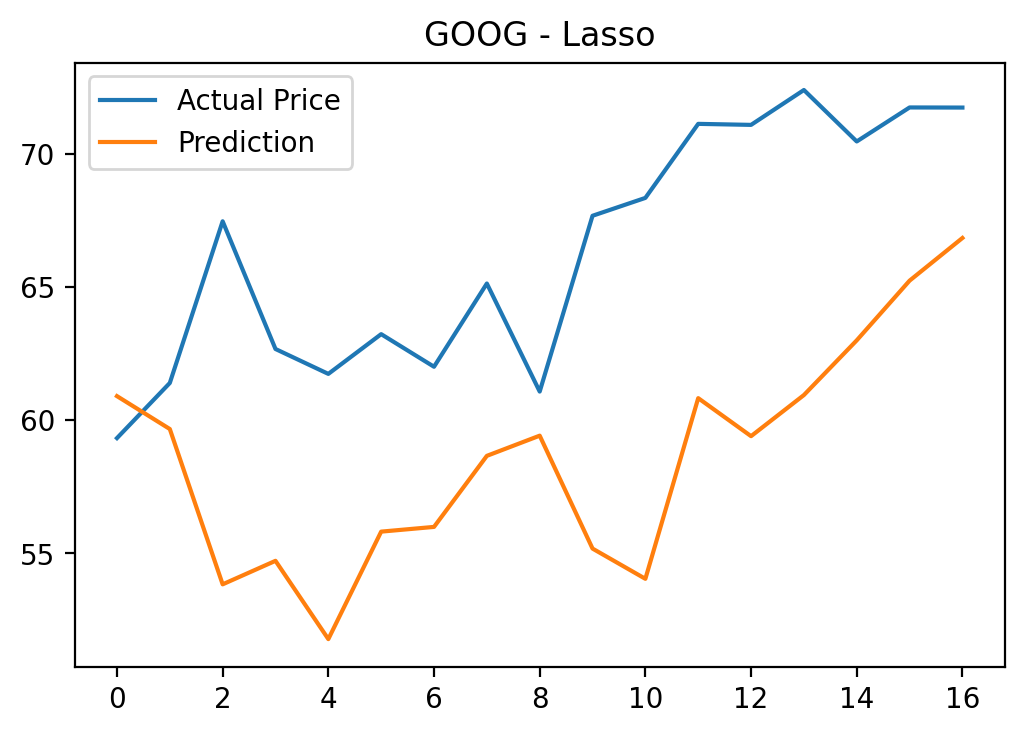

GOOG 8.904174014099764


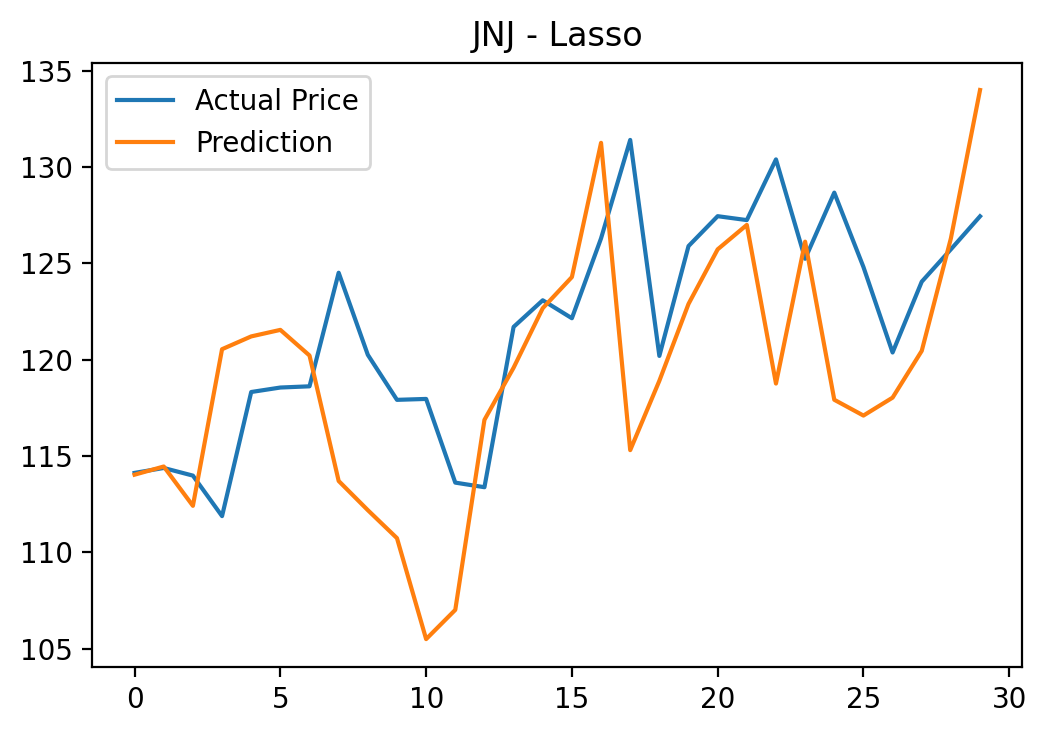

JNJ 6.380217354757348


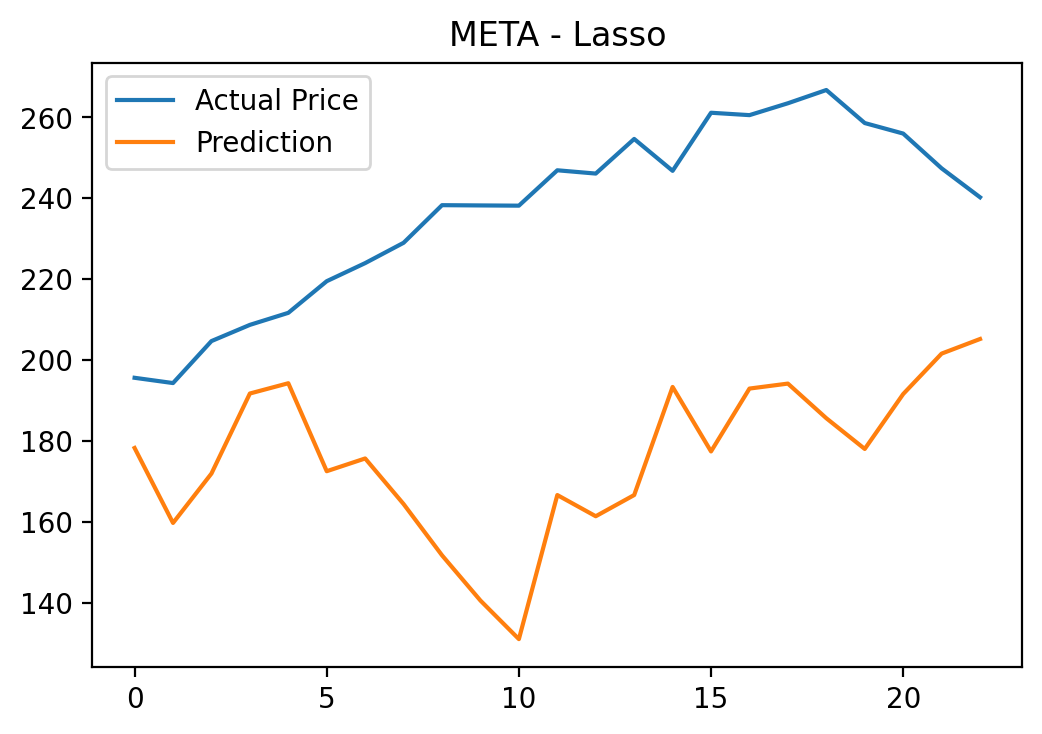

META 66.42006230085993


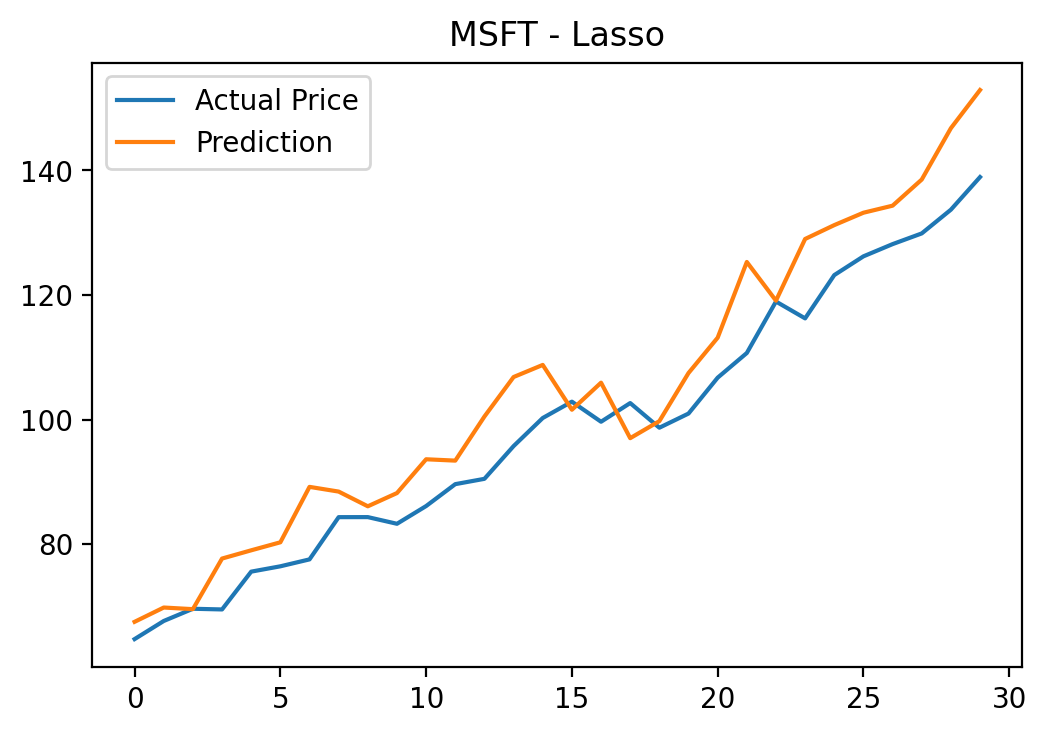

MSFT 7.694832000586797


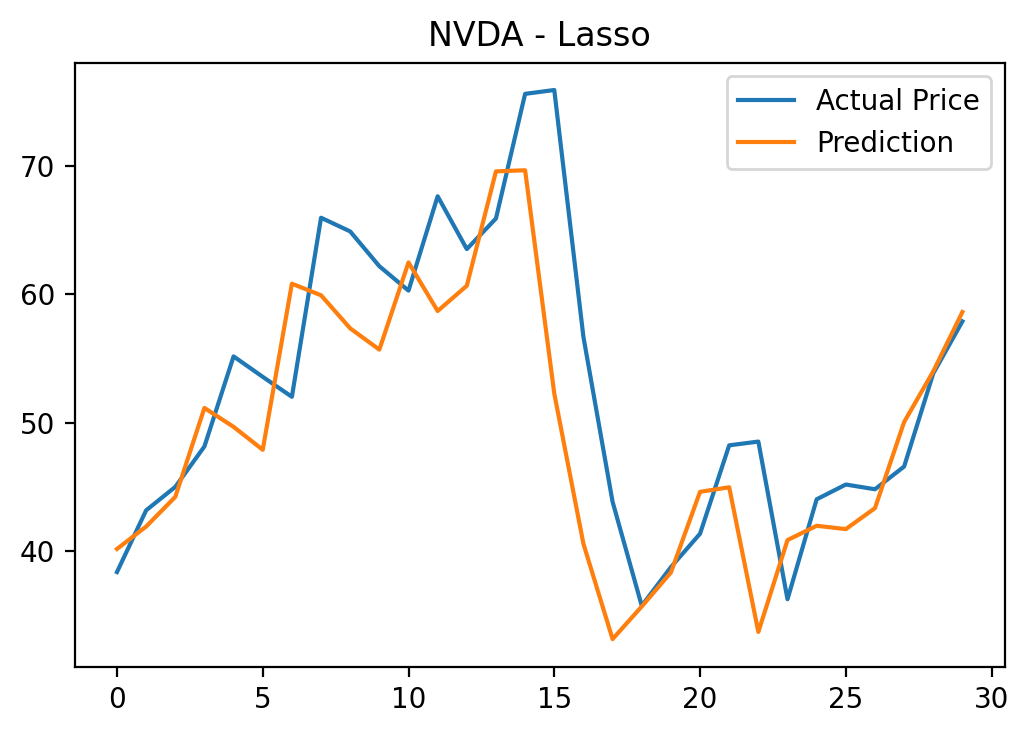

NVDA 7.4381954308807146


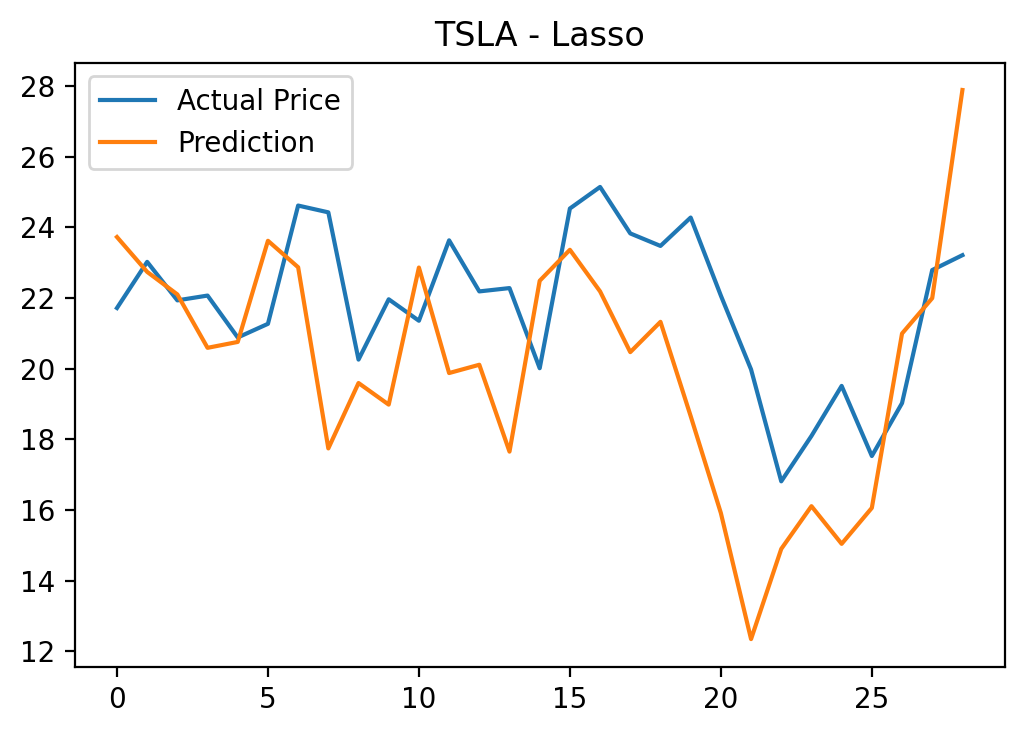

TSLA 3.35860094152573


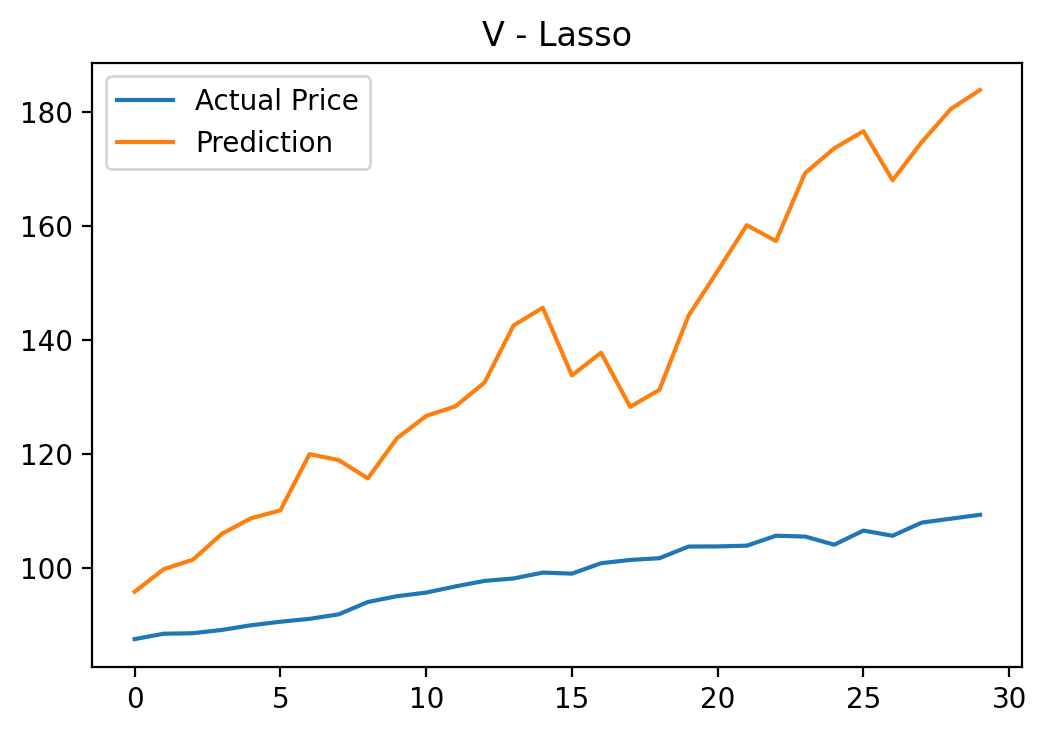

V 44.082071020775544


In [14]:
scores =dict()
selection_collect = dict()
for j in stock_list:
    freq = 'Monthly'
    stock = j
    price = pd.read_csv('../encode_price/'+freq+'/'+stock+'.csv')
    price = price.loc[(price.Date<='2019-12-31')&(price.Date>='2010-01-04'),:]
    price = price.loc[(price.Date>='2010-01-04'),:]
    y = price.adjusted_close.shift(-1).values[:-1]
    predictors = pd.read_csv('../predictors/Merged/'+freq+'/'+stock+'.csv')
    NLP = pd.read_csv('../predictors/NLP/Daily/NYT_macro_SA.csv')
    predictors = pd.merge(predictors,NLP,how='left',on=['Date'])
    predictors = predictors.loc[predictors.Date <= '2019-12-31',:]
    price.loc[:,'Date'] =[datetime.strptime(str,"%Y-%m-%d") for str in price.loc[:,'Date']]
    predictors.set_index('Date',inplace=True)
    predictors.fillna(0,inplace=True) 
    X = predictors.values[:-1]
    scores_cv = []
    for i in range(3,15):
        tscv = TimeSeriesSplit(n_splits=i)
        X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,shuffle=False)
        pipe = make_pipeline(MinMaxScaler(),Lasso())
    
        sfs = SequentialFeatureSelector(pipe,n_jobs = -1,n_features_to_select=6,scoring='neg_root_mean_squared_error')
        sfs.fit(X_train,y_train)
        X_train = sfs.transform(X_train)
        pipmodel = make_pipeline(MinMaxScaler(),LassoCV(cv=tscv))
        pipmodel.fit(X_train,y_train)
        X_test =  sfs.transform(X_test)
        y_pred = pipmodel.predict(X_train)
        score = mean_squared_error(y_pred, y_train)
        scores_cv.append(score)
    n_split = scores_cv.index(min(scores_cv))+2
    X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.25,shuffle=False)
    tscv = TimeSeriesSplit(n_splits=n_split)
    pipe = make_pipeline(MinMaxScaler(),LassoCV(cv=tscv))
    sfs = SequentialFeatureSelector(pipe,n_jobs = -1,n_features_to_select=5,scoring='neg_root_mean_squared_error')
    sfs.fit(X_train,y_train)
    X_train = sfs.transform(X_train)
    pipmodel = make_pipeline(MinMaxScaler(),LassoCV(cv=tscv))
    pipmodel.fit(X_train,y_train)
    selection_collect[j] = predictors.columns.values[sfs.get_support()]
    X_test =  sfs.transform(X_test)
    y_pred = pipmodel.predict(X_test)
    dates = price.Date.shift(-1).values[:len(X)]
    dates = dates[-len(y_test):]
    plt.plot(range(0,len(y_pred)),y_pred,label = 'Actual Price')
    plt.plot(range(0,len(y_pred)),y_test,label = 'Prediction')
    #plt.xticks(range(len(y_pred)),dates,rotate=45)
    plt.title(j + ' - Lasso')
    plt.legend()
    plt.savefig("../Lasso/plots/Daily/"+j+".png")
    plt.show()
    print(j,mean_squared_error(y_pred,y_test,squared=False) )
    scores[j] = mean_squared_error(y_pred,y_test,squared=False)

In [15]:
scores

{'AAPL': 12.884617214336282,
 'AMZN': 7.010056466810002,
 'BRK-B': 8.773904972254485,
 'GOOG': 8.904174014099764,
 'JNJ': 6.380217354757348,
 'META': 66.42006230085993,
 'MSFT': 7.694832000586797,
 'NVDA': 7.4381954308807146,
 'TSLA': 3.35860094152573,
 'V': 44.082071020775544}

- Feature Selection Summary

/var/folders/dy/lg_nw1516758wqn78l6dnqch0000gn/T/ipykernel_4087/907901423.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  mse_df = mse_df.append(scores,ignore_index=True)


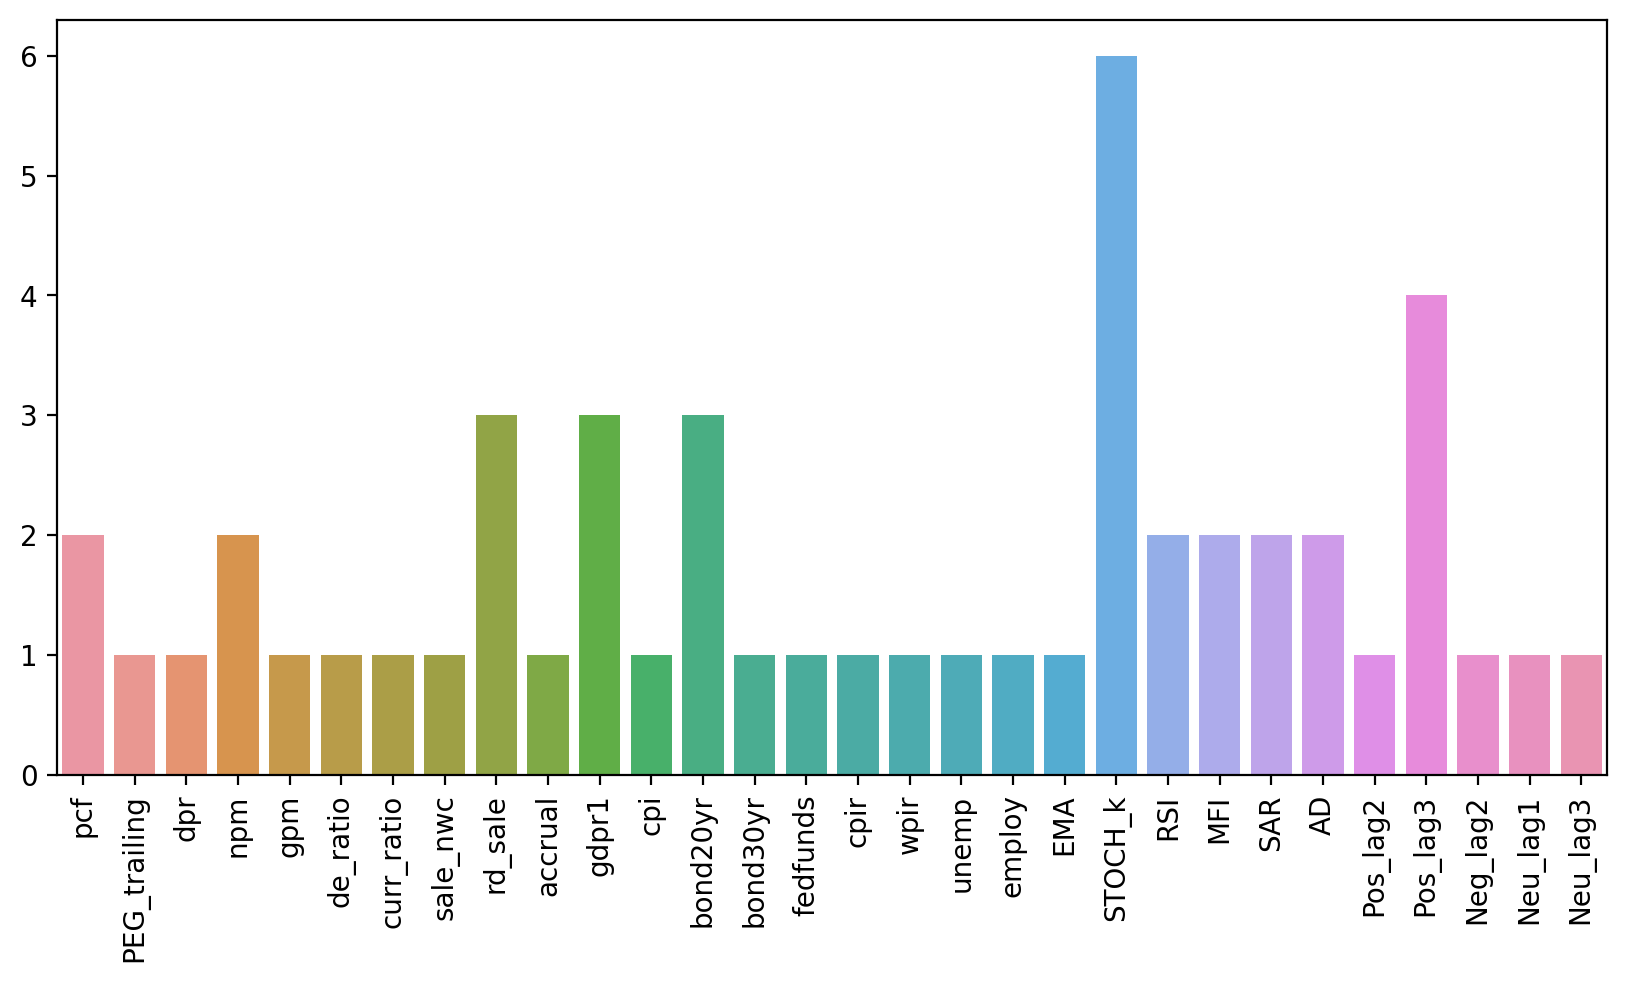

In [16]:
features = pd.Series(data = np.zeros(len(predictors.columns)),index=predictors.columns)
mse_df = mse_df.append(scores,ignore_index=True)
for stock in stock_list:
    curr_feature = selection_collect[stock]
    for curr in curr_feature:
        features.loc[curr] += 1
        
usefeature = features[features!=0].index.values.tolist()
plt.figure(figsize=[10,5])
ax = sns.barplot(features[features!=0].to_frame().T)
ax.set_xticklabels(labels=usefeature,rotation=90)
plt.savefig("../Lasso/plots/Monthly/Features.png")
plt.show()



In [19]:
mse_df.drop(2,axis=0,inplace=True)
mse_df

,AAPL,AMZN,BRK-B,GOOG,JNJ,META,MSFT,NVDA,TSLA,V
0,15.503565,1.458102,9.022853,1.137635,1.890239,4.669311,1.956995,1.311448,0.636341,46.157212
1,4.925687,2.872291,10.333022,2.491807,3.780936,10.327922,2.854402,4.02741,1.418365,25.427767
3,12.884617,7.010056,8.773905,8.904174,6.380217,66.420062,7.694832,7.438195,3.358601,44.082071


In [21]:
mse_df.index=['Daily','Weekly','Monthly']
mse_df.to_csv("../Lasso/MSE.csv",index=1)